## Import Libraries

In [3]:

import os
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten
from keras.layers import Dense,Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import secrets
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Data Loading and Processing

Setting the data path

In [4]:
# Define paths for dataset and model
base_path = "C:/Users/amaan/Desktop/444-Project"
data_path = os.path.join(base_path, "imgs", "train")
model_dir = os.path.join(base_path, "model", "vgg16_shallow_network")


print("Data Directory:", data_path)
print("Model Directory:", model_dir)



Data Directory: C:/Users/amaan/Desktop/444-Project\imgs\train
Model Directory: C:/Users/amaan/Desktop/444-Project\model\vgg16_shallow_network


### Data Pre-Processing Functions

In [5]:
# Preprocessing functions for the images
def enhance_brightness(img, value_increment):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img)
    v = cv2.add(v, value_increment)
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

def change_contrast(img, level):
   img = Image.fromarray(img.astype('uint8'))
   factor = (259 * (level + 255)) / (255 * (259 - level))
   def contrast(c):
        return 128 + factor * (c - 128)
   return np.array(img.point(contrast))

def preprocess_img(img):
   img = np.array(img)
   x = secrets.randbelow(2)
   if x == 0:
        # img = pad_img(img)
        img = enhance_brightness(img, secrets.randbelow(26))
        img = change_contrast(img, secrets.randbelow(51))
   else:
        # img = pad_img(img)
        img = change_contrast(img, secrets.randbelow(51))
        img = enhance_brightness(img, secrets.randbelow(26))
   return img


Setting up data augmentation configurations and loading training and testing datasets

In [6]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    shear_range=0.01,
    zoom_range=0.05,
    horizontal_flip=False,
    fill_mode="nearest",
    validation_split=0.2,
    preprocessing_function=preprocess_img
)



In [7]:
train_data = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=128,
    subset='training',
    shuffle=True
)


Found 17943 images belonging to 10 classes.


In [8]:
test_data = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=128,
    subset='validation',
    shuffle=True
)

Found 4481 images belonging to 10 classes.


## Init of VGG Deep Network Model

In [9]:
def initialize_deep_vgg16_model(input_shape, num_classes, learning_rate=1e-4):
    
    vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    model = Sequential() # Initialize the model
    model.add(vgg_base)
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer='glorot_normal'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Init of Model and Training/Evaluation

In [10]:
model = initialize_deep_vgg16_model(input_shape=(224, 224, 3), num_classes=10)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 500)               12544500  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
Total params: 27,264,198
Trainable params: 27,264,198
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Setup model checkpointing
checkpoint_path = os.path.join(model_dir, "model_vgg_deep-{epoch:02d}-{val_accuracy:.2f}.keras")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [13]:
# Start training
history = model.fit(train_data,
                    epochs=20,  
                    validation_data=test_data,
                    callbacks=[checkpoint_callback, early_stopping_callback])

# Save the model
model.save(os.path.join(model_dir, 'final_model_deep_net_batchwise.h5'))

Epoch 1/20
141/141 [==============================] - ETA: 0s - loss: 2.3937 - accuracy: 0.2678 
Epoch 1: val_accuracy improved from -inf to 0.58134, saving model to C:/Users/amaan/Desktop/444-Project\model\vgg16_shallow_network\model_vgg_deep-01-0.58.keras
141/141 [==============================] - 6988s 49s/step - loss: 2.3937 - accuracy: 0.2678 - val_loss: 1.1460 - val_accuracy: 0.5813
Epoch 2/20
141/141 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.7503 
Epoch 2: val_accuracy improved from 0.58134 to 0.93350, saving model to C:/Users/amaan/Desktop/444-Project\model\vgg16_shallow_network\model_vgg_deep-02-0.93.keras
141/141 [==============================] - 6785s 48s/step - loss: 0.7164 - accuracy: 0.7503 - val_loss: 0.2288 - val_accuracy: 0.9335
Epoch 3/20
141/141 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9423 
Epoch 3: val_accuracy improved from 0.93350 to 0.97277, saving model to C:/Users/amaan/Desktop/444-Project\model\vgg

## Data Visualization of Metrics

In [14]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

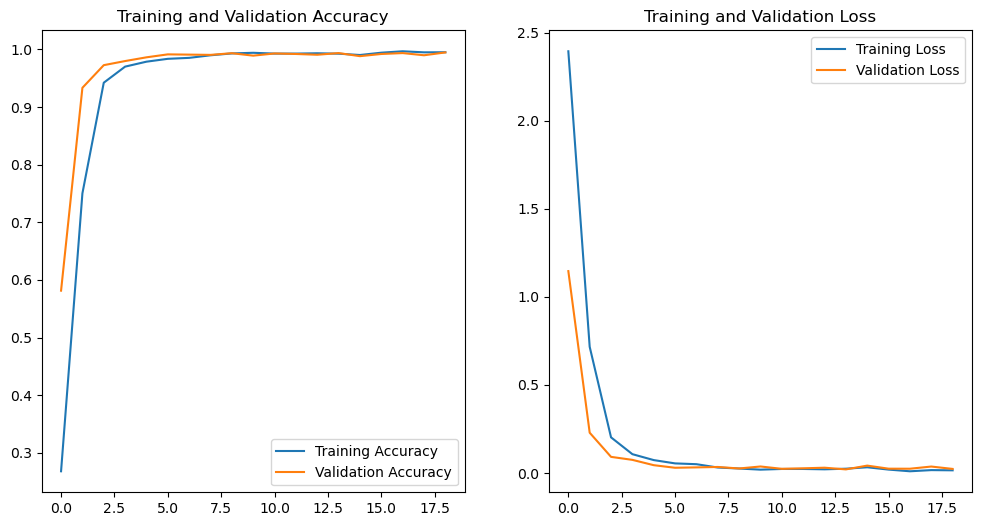

In [15]:
plot_training_history(history)

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy*100:.2f}%, Test loss: {test_loss:.2f}")

36/36 [==============================] - 362s 10s/step - loss: 0.0252 - accuracy: 0.9933
Test accuracy: 99.33%, Test loss: 0.03
